In [1]:
import numpy as np
import tensorflow as tf
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from pprint import pprint
from math import ceil
from time import time

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
BATCH_SIZE = 16

EPOCHS = 50
INIT_LR = 0.01

# Data Preparation

- load `train` and `test` subsets (CIFAR-10)
- split `train` into `train` + `valid` (80/20%, stratified split on labels)

- create data generators (with `keras.preprocessing.image.ImageDataGenerator`):
    - one ImageDataGenerator with data augmentation (horizontal flips, random translations) for train set
    - three ImageDataGenerator without data augmentation for train, valid and test subset 
        - why `train` ? : to fit Batch Norm statistics without augmentation 

In [3]:
print("... loading CIFAR10 dataset ...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

x_train, y_train = shuffle(x_train, y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=51)
# cast samples and labels
x_train = x_train.astype(np.float32) / 255.
x_val = x_val.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print("\tTRAIN - images {} | {}  - labels {} - {}".format(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype))
print("\tVAL - images {} | {}  - labels {} - {}".format(x_val.shape, x_val.dtype, y_val.shape, y_val.dtype))
print("\tTEST - images {} | {}  - labels {} - {}\n".format(x_test.shape, x_test.dtype, y_test.shape, y_test.dtype))

... loading CIFAR10 dataset ...
	TRAIN - images (40000, 32, 32, 3) | float32  - labels (40000,) - int32
	VAL - images (10000, 32, 32, 3) | float32  - labels (10000,) - int32
	TEST - images (10000, 32, 32, 3) | float32  - labels (10000,) - int32



In [4]:
generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=5,
                                                                height_shift_range=5,
                                                                fill_mode='constant',
                                                                cval=0.0,
                                                                rotation_range=90.,
                                                                horizontal_flip=True,
                                                                vertical_flip=True)

generator = tf.keras.preprocessing.image.ImageDataGenerator()

# python iterator object that yields augmented samples 
iterator_train_aug = generator_aug.flow(x_train, y_train, batch_size=BATCH_SIZE)

# python iterators object that yields not augmented samples 
iterator_train = generator.flow(x_train, y_train, batch_size=BATCH_SIZE)
iterator_valid = generator.flow(x_val, y_val, batch_size=BATCH_SIZE)
iterator_test = generator.flow(x_test, y_test, batch_size=BATCH_SIZE)

steps_per_epoch_train = int(ceil(iterator_train.n/BATCH_SIZE))
steps_per_epoch_val = int(ceil(iterator_valid.n/BATCH_SIZE))
steps_per_epoch_test = int(ceil(iterator_test.n/BATCH_SIZE))

label : 9
x : (16, 32, 32, 3) | float32
y : (16,) | int32


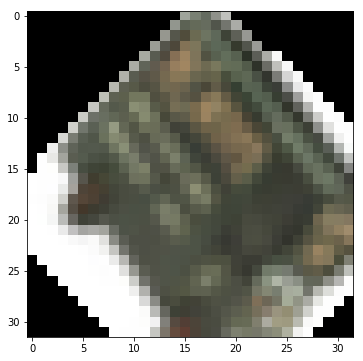

In [5]:
# test iterator with data augmentation
x, y = iterator_train_aug.next()

i = 0 
img = x[i]*255
label = y[i]
print("label : {}".format(label))
print("x : {} | {}".format(x.shape, x.dtype))
print("y : {} | {}".format(y.shape, y.dtype))

plt.figure(figsize=(6,6))
plt.imshow(img.astype(np.uint8))

Now data iterators are ready ! 

# Build a network with MovingFreeBatchNorm layers

In [6]:
from moving_free_batch_normalization import moving_free_batch_norm

In [7]:
# create a TensorFlow session
config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [8]:
# inputs: only placeholders (easy to use) !

with tf.name_scope('inputs'):
    # to images
    batch_x = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32)
    
    # to feed labels
    batch_y = tf.placeholder(shape=[None, ], dtype=tf.int64)
    
    # placeholders to set the learning phase (train vs inference)
    # this controls the behavior of BN layers 
    is_training_bn = tf.placeholder(shape=[], dtype=tf.bool)
    
    # select which statistics (mean, variance) to use in BN layers during inference 
    # when is_training_bn is False !
    use_moving_statistics = tf.placeholder(shape=[], dtype=tf.bool)
    
    # placeholder for learning rate for learning scheduling 
    learning_rate = tf.placeholder(shape=[], dtype=tf.float32)

In [9]:
# network similar to a VGG11 

with tf.name_scope('network'):
    ######################### 32x32 features per feature maps #########################
    x = tf.layers.conv2d(batch_x, filters=64, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format='channels_last', padding='same')
    ###################################################################################

    
    ######################### 16x16 features per feature maps #########################
    x = tf.layers.conv2d(x, filters=128, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format='channels_last', padding='same')
    ###################################################################################
    
    ######################### 8x8 features per feature maps #########################
    x = tf.layers.conv2d(x, filters=256, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn, use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.conv2d(x, filters=256, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format='channels_last', padding='same')
    ###################################################################################
    
    ######################### 4x4 features per feature maps #########################
    x = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn, use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.max_pooling2d(x, pool_size=2, strides=2, data_format='channels_last', padding='same')
    ###################################################################################
    
    ######################### 2x2 features per feature maps #########################
    x = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn, use_moving_statistics=use_moving_statistics, momentum=0.99)
    x = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, use_bias=True,
                         activation=tf.nn.relu, data_format='channels_last', padding='same')
    x = moving_free_batch_norm(x, axis=-1, training=is_training_bn,
                               use_moving_statistics=use_moving_statistics, momentum=0.99)
    ###################################################################################
    
    ######################### Global Average Pooling #########################
    x = tf.reduce_mean(x, axis=[1, 2]) 
    logits = tf.layers.dense(x, units=10, use_bias=True)
    ###################################################################################

In [10]:
model_vars = tf.trainable_variables()
pprint(model_vars)

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization_1/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization_1/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization_2/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'moving_free_batch_normalization_2/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv2d_3/kernel:0' shape=(3, 3,

In [11]:
# operations to update moving averages in batch norm layers
# to run before updating weights ! (with tf.control_dependencies())
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# these operations are new, specific to MovingFreeBatchNorm layers.
# operations to updates (mean, variance, n) in batch norm layers 
update_bn_ops = tf.get_collection('UPDATE_BN_OPS')
# operations to reset (mean, variance, n) to zero 
reset_bn_ops = tf.get_collection('RESET_BN_OPS')

pprint(update_ops)
pprint(update_bn_ops)
pprint(reset_bn_ops)

# group these operations
update_ops = tf.group(*update_ops)
update_bn_ops = tf.group(*update_bn_ops)
reset_bn_ops = tf.group(*reset_bn_ops)

[<tf.Operation 'network/moving_free_batch_normalization/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_1/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_1/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_2/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_2/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_3/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_3/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_4/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_4/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'network/moving_free_batch_normalization_5/AssignMovingAvg'

In [12]:
# add loss and accuracy 
with tf.name_scope('loss'):
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                                            labels=batch_y))
    acc_tf = tf.reduce_mean(tf.cast(tf.equal(batch_y, tf.argmax(logits, axis=1)), dtype=tf.float32))

In [13]:
# optimization with SGD x Momentum
with tf.name_scope('optimizer'):
    opt = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
    
    # even with MovingFreeBatchNorm we can update the moving statistics
    with tf.control_dependencies([update_ops,]):
        train_op = opt.minimize(loss_tf, var_list=model_vars)

In [14]:
# initialize all parameters 
global_init_op = tf.global_variables_initializer()
sess.run(global_init_op)

# Launch training 

In [15]:
# constant learning rate
def get_learning_rate(step, epoch, steps_per_epoch_train):
    return INIT_LR

## Launch traninig 
- create a function to fit statistics with train subset
- create a function to run inference on [train/]val/test subsets (with/without moving statistics)

In [16]:
def fit_bn_statistics():
    # reset new BN statistics
    sess.run(reset_bn_ops)
    
    # when updating, set is_training_bn=True
    feed_dict = {is_training_bn: True, use_moving_statistics: True}
    for _ in range(steps_per_epoch_train):
        # use sample from the train set, without data augmentation
        x, y = iterator_train.next()
        feed_dict[batch_x] = x
        sess.run(update_bn_ops, feed_dict=feed_dict)

In [17]:
def inference(iterator, with_moving_statistics=True):
    
    feed_dict = {is_training_bn: False,
                 use_moving_statistics: with_moving_statistics}
    
    all_acc = []
    all_loss = []
    nb_steps = int(ceil(iterator.n/BATCH_SIZE))
    
    for _ in range(nb_steps):
        x, y = iterator.next()
        feed_dict[batch_x] = x
        feed_dict[batch_y] = y
        acc_v, loss_v = sess.run([acc_tf, loss_tf], feed_dict=feed_dict)
        all_acc.append(acc_v)
        all_loss.append(loss_v)
    
    return np.mean(all_acc), np.mean(all_loss)

In [18]:
%%time
# test your random model ? 
acc, loss = inference(iterator_valid, with_moving_statistics=True)
print("Random model : acc={:.5f}   loss={:.5f}".format(acc, loss))

Random model : acc=0.10410   loss=2.30254
CPU times: user 19.6 s, sys: 7.76 s, total: 27.4 s
Wall time: 26.5 s


In [19]:
%%time 
# now fit batch norm statistics and make inference again 
fit_bn_statistics()
acc, loss = inference(iterator_valid, with_moving_statistics=False)
print("Random model : acc={:.5f}   loss={:.5f}".format(acc, loss))

Random model : acc=0.09230   loss=2.53787
CPU times: user 1min 33s, sys: 36 s, total: 2min 9s
Wall time: 2min 5s


In [ ]:
%%time

step = 0
start = time()

acc_train = []
loss_train = []

acc_val = []
loss_val = []

acc_val_bn = []
loss_val_bn = []

feed_dict_train = {is_training_bn: True, 
                   use_moving_statistics:True,}

for epoch in range(EPOCHS):
    
    acc = []
    loss = []
    for _ in range(steps_per_epoch_train):
        
        # get samples from the train set, with data augmentation 
        x, y =  iterator_train_aug.next()
        feed_dict_train[batch_x] = x
        feed_dict_train[batch_y] = y
        feed_dict_train[learning_rate] = get_learning_rate(step, epoch, steps_per_epoch_train)
        
        acc_v, loss_v, _ = sess.run([acc_tf, loss_tf, train_op], feed_dict=feed_dict_train)
        acc.append(acc_v)
        loss.append(loss_v)
        step += 1
        
    acc = np.mean(acc)
    loss = np.mean(loss)
    acc_train.append((epoch,acc))
    loss_train.append((epoch,loss))
    print("TRAIN @ EPOCH {} : acc={:.5f}  loss={:.5f}  in {:.3f} s".format(epoch, acc, loss,
                                                                               time()-start))
    
    acc, loss = inference(iterator_valid, with_moving_statistics=True)
    acc_val.append((epoch,acc))
    loss_val.append((epoch,loss))
    print("VALID @ EPOCH {} : acc={:.5f}   loss={:.5f}  in {:.3f} s".format(epoch, acc, loss,
                                                                            time()-start))

    # now fit batch norm statistics and make inference again 
    fit_bn_statistics()
    acc, loss = inference(iterator_valid, with_moving_statistics=False)
    acc_val_bn.append((epoch,acc))
    loss_val_bn.append((epoch,loss))
    print("VALID updated BN @ EPOCH {} : acc={:.5f}   loss={:.5f}  in {:.3f} s".format(epoch, acc,
                                                                                       loss, time()-start))


TRAIN @ EPOCH 0 : acc=0.31610  loss=1.87514  in 448.770 s
VALID @ EPOCH 0 : acc=0.40390   loss=1.64809  in 472.807 s
VALID updated BN @ EPOCH 0 : acc=0.40760   loss=1.65106  in 596.536 s
TRAIN @ EPOCH 1 : acc=0.40047  loss=1.66038  in 1043.320 s
VALID @ EPOCH 1 : acc=0.43330   loss=1.62047  in 1067.253 s
